In [1]:
#函数所需
import numpy as np
from numpy.random import default_rng
from scipy.stats import multivariate_normal
from numba import njit, prange
from numpy.linalg import norm

#运行所需
import os, time
import pandas as pd
import multiprocessing as mp
from scipy.integrate import solve_ivp
import pickle




#################################################################################################################
################函数文件

def randtemp_param(N, kw):
    rng=kw.get('rng',np.random)
    """
    为consumer生成随机的温度相关特征参数。

    N
    含义：消费者（consumers）的数量。
    类型：单个整数（int）。
    作用：决定生成的参数矩阵的行数（每个消费者对应一行）。

    kw
    含义：参数字典，包含以下键：
    'L'：泄漏率向量，长度为 N 的一维数组（np.ndarray）。
    'rho_t'：相关系数，单个数值（float）或长度为 2 的数组（代码中未明确，但根据上下文推断为单个数值）。
    类型：字典（dict）。
    作用：提供生成参数所需的额外配置（如泄漏率和相关系数）。
    """
    L = kw['L'] # leakage
    rho_t = kw['rho_t']
    L_v = np.mean(L)
    B0_m = -1.4954 
    B0_CUE = 0.1953
    B0_u = np.log(np.exp(B0_m) / (1 - L_v - B0_CUE)) 
    B0 = np.array([B0_u, B0_m]) 
    B0_var = 0.17 * np.abs(B0) 
    E_mean = np.array([0.8146, 0.5741]) 
    E_var = 0.1364 * E_mean 
    cov_xy = rho_t * np.sqrt(B0_var * E_var)

    cov_u = np.array([[B0_var[0], cov_xy[0]], [cov_xy[0], E_var[0]]]) 
    cov_m = np.array([[B0_var[1], cov_xy[1]], [cov_xy[1], E_var[1]]]) 

    allu = multivariate_normal.rvs(mean=[B0[0], E_mean[0]], cov=cov_u, size=N).T 
    allm = multivariate_normal.rvs(mean=[B0[1], E_mean[1]], cov=cov_m, size=N).T 

    B = np.column_stack((np.exp(allu[0]), np.exp(allm[0]))) 
    E = np.column_stack((allu[1], allm[1])) 

    Tpu = 273.15 + rng.normal(35, 5, N) 
    Tpm = Tpu + 3 
    Tp = np.column_stack((Tpu, Tpm)) 

    return B, E, Tp

    """
    返回三个 N x 2 的矩阵

    B
    含义：基础速率（base rates），第一列为摄取速率（u），第二列为呼吸/死亡率（m）。
    类型：N x 2 的 np.ndarray。
    生成方式：从多元正态分布采样后取指数。
    
    E
    含义：活化能（activation energies），第一列为摄取的活化能，第二列为呼吸的活化能。
    类型：N x 2 的 np.ndarray。
    生成方式：直接来自多元正态分布采样。
    
    Tp
    含义：峰值温度（peak temperatures），第一列为摄取的峰值温度，第二列为呼吸的峰值温度（呼吸比摄取高 3°C）。
    类型：N x 2 的 np.ndarray。
    生成方式：从正态分布生成摄取的峰值温度，呼吸温度在此基础上加 3。


    ===========================

    N 的变化会直接改变输出矩阵的行数（如 N=5 → B 的形状为 5x2）。

    kw 中的 'L' 和 'rho_t' 会影响参数生成的均值和协方差矩阵，从而改变 B 和 E 的具体数值。例如：
    L 的均值用于计算 B0_u，进而影响 B 的第一列。
    rho_t 控制 B 和 E 的协方差，影响随机生成的参数相关性。

    
    ====================================潜在问题与代码检查==========================================

    输入校验缺失: 
    函数未检查 kw 是否包含必需的键 'L' 和 'rho_t'，若缺失会抛出 KeyError。
    建议添加异常处理或默认值（如 kw.get('L', np.ones(N))）。

    rho_t 的维度假设:
    代码假设 rho_t 是标量，但若传入数组（如 rho_t=[-0.5, -0.5]），cov_xy 的计算可能不符合预期（需确认 rho_t 的预期类型）。
    
    数值稳定性:
    B0_u 的计算涉及 1 - L_v - B0_CUE，若 L_v + B0_CUE >= 1 会导致对数参数为负，引发 RuntimeWarning。

    """











def temp_trait(N, kw):
    """
    根据类似阿伦尼乌斯的热性能曲线计算温度相关特性缩放。

    N
    含义：消费者（consumers）的数量。
    类型：单个整数（int）。
    作用：决定生成参数矩阵的行数（每个消费者对应一行）。

    kw
    含义：参数字典，必须包含以下键：
        'T'：当前环境温度（单位：开尔文），单个数值（float）。
        'Tr'：参考温度（单位：开尔文），单个数值（float）。
        'Ed'：去活化能（单位：电子伏特），单个数值（float）。
        'L'：泄漏率向量，长度为 N 的一维数组（np.ndarray）。
        'rho_t'：相关系数，单个数值（float）或数组（根据 randtemp_param 的假设）。
    类型：字典（dict）。
    作用：提供温度参数和生成随机参数所需的配置。
    """
    k = 0.0000862 
    T = kw['T']
    Tr = kw['Tr']
    Ed = kw['Ed']

    B, E, Tp = randtemp_param(N, kw) 

    # uptake rate u(T)
    temp_p_u = B[:, 0] * np.exp((-E[:, 0] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 0] / (Ed - E[:, 0])) * np.exp(Ed / k * (1 / Tp[:, 0] - 1 / T)))

    # respiration rate m(T)
    temp_p_m = B[:, 1] * np.exp((-E[:, 1] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 1] / (Ed - E[:, 1])) * np.exp(Ed / k * (1 / Tp[:, 1] - 1 / T)))

    temp_p = np.column_stack((temp_p_u, temp_p_m))  # shape (N,2)

    return temp_p, B, E, Tp

    """
    返回四个变量：

    temp_p
    含义：温度缩放后的性状值，第一列为摄取速率（u(T)），第二列为呼吸速率（m(T)）。
    类型：N x 2 的 np.ndarray。
    计算公式：基于修正的阿伦尼乌斯方程（含高温失活项）。

    B
    含义：基础速率（base rates），同 randtemp_param 的输出，N x 2 矩阵。
    类型：np.ndarray。

    E
    含义：活化能（activation energies），同 randtemp_param 的输出，N x 2 矩阵。
    类型：np.ndarray。

    Tp
    含义：峰值温度（peak temperatures），同 randtemp_param 的输出，N x 2 矩阵。
    类型：np.ndarray。

    ===========================

    N 的变化：
    直接影响所有输出矩阵的行数（如 N=10 → temp_p 为 10x2）。

    kw 的变化：
    'T'、'Tr'、'Ed' 会改变 temp_p 的计算结果（温度依赖公式中的变量）。
    'L' 和 'rho_t' 通过 randtemp_param 影响 B、E、Tp 的生成，进而间接影响 temp_p。

    ====================================潜在问题与代码检查==========================================

    输入校验缺失:
    函数未检查 kw 是否包含必需的键（'T'、'Tr'、'Ed'、'L'、'rho_t'），缺失时会抛出 KeyError。
    建议添加异常处理或默认值（如 kw.get('T', 300)）。

    数值稳定性问题:
    分母项 (Ed - E[:, 0]) 和 (Ed - E[:, 1]) 可能为负数或零，导致：
            除零错误（若 Ed == E[:, i]）。
            指数爆炸（若 Ed < E[:, i]，使分母为负）。
    
    单位一致性:
    k（玻尔兹曼常数）的单位为 0.0000862 eV/K，但代码中未明确说明，需确保输入参数的单位匹配（如 Ed 也应为 eV）。

    温度参数范围:
    若 T 或 Tp 接近零，1/T 会导致数值溢出。建议添加范围检查（如 T > 0）。

    输出一致性:
    文档字符串中描述 temp_p 为 "vector of size N"，但实际返回 N x 2 矩阵。需修正文档以避免歧义。


    """




# Default parameter-generating functions

def def_m(N, M, kw):
    return np.ones(N)
# 返回值：长度为 N 的全1向量，表示每个消费者的呼吸/死亡率


def def_rho(N, M, kw):
    return np.ones(M)
# 返回值：长度为 M 的全1向量，表示每个资源的供给率


def def_omega(N, M, kw):
    return np.ones(M)
# 返回值：长度为 M 的全1向量，表示每个资源的损失率


def def_u(N, M, kw):
    rng = kw.get('rng', np.random)
    return rng.dirichlet(np.ones(M), size=N)
# 返回值：N x M 的摄取矩阵，每行是Dirichlet分布生成的M维向量（和为1）


def def_l(N, M, kw):
    L = kw['L']
    rng = kw.get('rng', np.random) 
    l = np.zeros((N, M, M))
    phi = np.ones(M)
    for i in range(N):
        for alpha in range(M):
            draw = rng.dirichlet(alpha=phi)
            l[i, alpha, :] = draw * L[i]
    return l
# 返回值：泄漏转换张量，形状 (N, M, M)，每个 [i,alpha,:] 是Dirichlet向量乘以 L[i]

    """
    ====================================潜在问题与代码检查==========================================

    未检查 kw['L'] 的合法性：
    若 kw['L'] 长度不为 N，会抛出 ValueError。
    若 L[i] 为负，可能导致负泄漏率（需物理意义验证）。

    效率问题：
    双重循环（N x M 次Dirichlet采样）在 N 和 M 较大时性能较差。

    """




def generate_params(N,
                     M,
                     f_m=def_m,
                     f_rho=def_rho,
                     f_omega=def_omega,
                     f_u=def_u,
                     f_l=def_l,
                     **kwargs):

   
    """
    生成与温度相关的 MiCRM 参数

    必需参数：

        N
        含义：消费者（consumers）的数量。
        类型：单个整数（int）。

        M
        含义：资源（resources）的数量。
        类型：单个整数（int）。
    
    
    可选参数生成函数（默认使用预设函数）：

        f_m：生成呼吸/死亡率 m 的函数，返回长度为 N 的向量。
        f_rho：生成资源供给率 rho 的函数，返回长度为 M 的向量。
        f_omega：生成资源损失率 omega 的函数，返回长度为 M 的向量。
        f_u：生成摄取矩阵 u 的函数，返回 N x M 矩阵。
        f_l：生成泄漏张量 l 的函数，返回 N x M x M 张量。
    
    关键字参数 **kwargs：

        必须包含的键：

            'T'：环境温度（单位：开尔文），单个数值（float）。
            'Tr'：参考温度（单位：开尔文），单个数值（float）。
            'Ed'：去活化能（单位：电子伏特），单个数值（float）。
            'L'：泄漏率向量，长度为 N 的一维数组（np.ndarray）。
            'rho_t'：相关系数，单个数值（float）。

        可选键：其他用户自定义参数（如随机数生成器 'rng'）

    """

    # Copy kwargs for internal use
    kw = dict(kwargs)

    # Temperature-dependent traits, as defined in previous code block
    tt, B, E, Tp = temp_trait(N, kw) # according to previously defined temp_trait function
    # tt is the first output of the temp_trait function, which is temp_p


    kw['tt'] = tt

    # Generate consumer parameters
    m = f_m(N, M, kw) # Respiration (mortality) rates
    u = f_u(N, M, kw) # Uptake matrix

    # Leakage-transformation tensor
    l = f_l(N, M, kw)      # Leakage-transformation

    # Total leakage per consumer-resource pair
    lambda_ = np.sum(l, axis=2)  # shape (N, M)

    # Resource parameters
    rho = f_rho(N, M, kw)
    omega = f_omega(N, M, kw)

    # Assemble base parameter dict
    params = {
        'N': N,
        'M': M,
        'u': u,
        'm': m,
        'l': l,
        'rho': rho,
        'omega': omega,
        'lambda': lambda_,
        'L': L,
        'B': B,
        'E': E,
        'Tp': Tp,
        'tt': tt
    }
   
    params.update(kwargs)

    return params 

    """
    返回一个参数字典 params，包含以下键：

    键名	                              含义	                                类型/形状
    'N', 'M'	                    消费者和资源的数量	                          整数（int）
    'u'	                          温度修正后的摄取矩阵	                    N x M 矩阵（np.ndarray）
    'm'	                         温度修正后的呼吸/死亡率	                长度 N 的向量（np.ndarray）
    'l'	                              泄漏转换张量	                       N x M x M 张量（np.ndarray）
    'rho'	                           资源供给率	                      长度 M 的向量（np.ndarray）
    'omega'	                           资源损失率	                      长度 M 的向量（np.ndarray）
    'lambda'	                 总泄漏率（l 沿最后一维求和）	             N x M 矩阵（np.ndarray）
    'B', 'E', 'Tp', 'tt'	        温度相关中间参数	                    N x 2 矩阵（np.ndarray）
    其他	                       通过 **kwargs 传入的参数	                    依具体参数类型而定

    

    ====================================潜在问题与代码检查==========================================
    输入校验缺失：
    未检查 kwargs 是否包含必需的键（'T'、'Tr'、'Ed'、'L'、'rho_t'），缺失时会抛出 KeyError。

    f_l 调用不一致：
    f_l 的调用为 f_l(N, M, L)，但默认 def_l 定义是 def_l(N, M, kw)，导致参数不匹配。

    错误表现：
    若用户传入自定义 f_l，可能因参数不符而报错。
    修复建议：
    统一调用方式为 f_l(N, M, kw)，并将 L 放入 kw 中。

    lambda_ 的计算冗余：
    lambda_ = np.sum(l, axis=2) 可直接在需要时计算，无需存储在 params 中。

    文档与实际行为不符：
    文档提到返回 'lambda'，但代码中键名为 'lambda_'（下划线后缀），需保持一致。

    随机性控制未明确：
    若 temp_trait 或参数生成函数依赖随机数生成器（rng），需在文档中说明应通过 kwargs 传入 'rng'。

    """





#@njit
def MiCRM_dxx(x, t, N, M, u, l, rho, omega, m):
    """
    函数输入
    x
    含义：系统状态向量，包含消费者和资源的当前浓度。
    类型：长度为 N + M 的一维数组（np.ndarray）。
    结构：前 N 个元素为消费者浓度，后 M 个元素为资源浓度。
    """
    dx = np.zeros(N + M)
    # consumer dynamics
    for i in range(N):
        dx[i] = -m[i] * x[i]
        for alpha in range(M):
            res_idx = N + alpha
            uptake = x[i] * x[res_idx] * u[i, alpha]
            dx[i] += uptake
            for beta in range(M):
                dx[i] -= uptake * l[i, alpha, beta]
    # resource dynamics
    for alpha in range(M):
        idx = N + alpha
        dx[idx] = rho[alpha] - omega[alpha] * x[idx]
        for i in range(N):
            dx[idx] -= u[i, alpha] * x[idx] * x[i]
            for beta in range(M):
                dx[idx] += x[N + beta] * x[i] * u[i, beta] * l[i, beta, alpha]
    return dx

    """
    返回值 dx：
    含义：系统状态向量的时间导数（消费者和资源浓度的变化率）。
    类型：长度为 N + M 的一维数组（np.ndarray）。
    结构：前 N 个元素为消费者浓度的变化率，后 M 个元素为资源浓度的变化率。


    ====================================潜在问题与代码检查==========================================
    输入维度校验缺失：
    函数假设所有输入的维度匹配（如 u 为 N x M，l 为 N x M x M），但未显式检查。
    风险：若输入维度不匹配（如 u 行数不足 N），可能导致索引越界错误。

    泄漏项符号争议：
    消费者动态中，泄漏损失项为 -= uptake * l[i, alpha, beta]，而资源动态中泄漏补充项为 +=。

    物理意义：需确保 l[i, alpha, beta] 的定义方向与模型假设一致（通常合理，但需文档说明）。

    时间参数 t 未使用：
    虽然 t 是ODE求解器的标准接口参数，但未参与计算。若需时间依赖的动态（如季节性变化），需修改逻辑。

    数值稳定性：
    若 x[i] 或 x[res_idx] 接近零，可能导致浮点误差（但这是模型本身特性，非代码错误）。


    """


# In solve_ivp, use a wrapper to pass jit arguments:
def MiCRM_dxx_numba_wrapper(t, x, p):
    # Unpack parameters directly for the JIT function
    return MiCRM_dxx(x, t,
                         p['N'], p['M'],
                         p['u'], p['l'],
                         p['rho'], p['omega'],
                         p['m'])
    """
    返回值：

    含义：系统状态向量的时间导数（消费者和资源浓度的变化率）。

    类型：长度为 N + M 的一维数组（np.ndarray）。

    计算方式：调用 MiCRM_dxx 函数，传入解包的参数。

    ====================================潜在问题与代码检查==========================================
    参数字典完整性检查缺失：
    函数假设 p 包含所有必需的键（如 'N'、'M'、'u' 等），但未做校验。
    风险：若 p 缺少某个键（如误将 'rho' 写为 'supply'），会抛出 KeyError。
    
    参数维度一致性未验证：
    函数未检查 p['u']、p['l'] 等参数的维度是否与 p['N'] 和 p['M'] 匹配。
    风险：若 p['u'].shape != (N, M)，会导致 MiCRM_dxx 内部索引错误。

    时间参数 t 的冗余性：
    t 未被实际使用，但为ODE求解器（如 solve_ivp）的标准接口参数。若需支持时间依赖的动态（如季节性变化），需修改 MiCRM_dxx 的逻辑。

    """



def eff_LV_params(p, sol, verbose=False):
    """
    函数输入:

    p
    含义：MiCRM模型的参数字典，必须包含以下键：
        'N'：消费者数量，单个整数（int）。
        'M'：资源数量，单个整数（int）。
        'l'：泄漏张量，形状为 (N, M, M) 的三维数组（np.ndarray）。
        'rho'：资源供给率，长度为 M 的向量（np.ndarray）。
        'omega'：资源损失率，长度为 M 的向量（np.ndarray）。
        'm'：消费者死亡率，长度为 N 的向量（np.ndarray）。
        'u'：摄取矩阵，形状为 (N, M) 的二维数组（np.ndarray）。
        'lambda'：总泄漏率矩阵，形状为 (N, M) 的二维数组（np.ndarray）。
    
    sol
    含义：MiCRM模型的数值解（通常来自 solve_ivp）。
    类型：scipy.integrate.OdeResult 或类似对象，需包含属性 .y。
    .y 的结构：形状为 (N+M, T) 的二维数组，其中 T 为时间步数，最后一列（sol.y[:, -1]）为平衡态浓度。

    verbose
    含义：是否返回中间计算矩阵（A 和 dR）。
    类型：布尔值（bool），默认为 False。

    """
    M, N = p['M'], p['N']
    l    = p['l']        # (N, M, M)
    rho  = p['rho']      # (M,)
    omega= p['omega']    # (M,)
    m    = p['m']        # (N,)
    u    = p['u']        # (N, M)
    lam  = p['lambda']   # (N, M)

    # Equilibrium values
    Ceq = sol.y[:N, -1]  # (N,)
    Req = sol.y[N:, -1]  # (M,)

    # 1) Build A (M×M):
    #    A = -diag(omega) + ∑_i [ l[i,α,β]*u[i,β]*Ceq[i] ]  -  diag_i( ∑_i u[i,α]*Ceq[i] )
    #
    # First term: -omega on diagonal
    A = -np.diag(omega)

    # add sum_i l[i,:,:] * (u[i,:]*Ceq[i]) broadcasted over β
    # compute W[i,β] = u[i,β]*Ceq[i]
    W = u * Ceq[:, None]           # (N, M)
    # Now add ∑_i l[i,α,β] * W[i,β]  → sum over i,β
    # We want for each (α,β): sum_i l[i,α,β]*W[i,β]
    # That is: contract i and β
    A += np.einsum('ib, iab -> ab', W, l)  # yields (M, M)

    # subtract ∑_i u[i,β]*Ceq[i] on the diagonal
    diag_sub = W.sum(axis=0)       # (M,)
    A[np.diag_indices(M)] -= diag_sub

    # 2) Inverse of A
    invA = np.linalg.inv(A)

    # 3) Compute dR = ∂R/∂C  (M×N):
    #    dR[α,j] = ∑_{β,γ} invA[α,β]*u[j,β]*Req[γ]*(δ(β,γ) - l[j,β,γ])
    #
    # Define T[j,β,γ] = u[j,β]*Req[γ]*(δ(β,γ) - l[j,β,γ])
    #   δ(β,γ) - l[j,β,γ] → eye(M) - l[j]
    eyeM = np.eye(M)
    # broadcast to (N, M, M):
    D = (eyeM[None,:,:] - l)       # (N, M, M)
    T = u[:,:,None] * Req[None,None,:] * D  # (N, M, M)

    # Now dR[α,j] = ∑_{β,γ} invA[α,β] * T[j,β,γ]
    #   = for each j: row α of invA dot T[j,β,:].sum over γ
    # First sum T over γ: S[j,β] = ∑_γ T[j,β,γ]
    S = T.sum(axis=2)              # (N, M)
    # Now for each j: dR[:,j] = invA @ S[j,:]
    dR = (invA @ S.T)              # (M, N)

    # 4) Effective interaction matrix α = A_thing @ dR
    A_thing = u * (1 - lam)        # (N, M)
    # α[i,j] = ∑_α A_thing[i,α] * dR[α,j]
    alpha = A_thing @ dR           # (N, N)

    # 5) Intrinsic growth r = O - P - m
    #    O[i] = ∑_α A_thing[i,α] * Req[α]
    #    P[i] = ∑_j α[i,j] * Ceq[j]
    O = A_thing @ Req              # (N,)
    P = alpha @ Ceq                # (N,)
    r_eff = O - P - m              # (N,)

    result = {'alpha': alpha, 'r': r_eff, 'N': N}
    if verbose:
        result.update({'dR': dR, 'A': A})
    return result

"""
函数输出:
返回一个字典 result，包含以下键：

键名	                                含义	                                    类型/形状
'alpha'	                     有效Lotka-Volterra相互作用矩阵	                    N x N 矩阵（np.ndarray）
'r'	                          有效Lotka-Volterra生长率向量	                    长度 N 的向量（np.ndarray）
'N'	                            消费者数量（直接返回输入值）	                        整数（int）
'dR'	               （仅 verbose=True 时返回）资源对消费者的响应矩阵	            M x N 矩阵（np.ndarray）
'A'	                     （仅 verbose=True 时返回）资源动态的雅可比矩阵	            M x M 矩阵（np.ndarray）

====================================潜在问题与代码检查==========================================
输入校验缺失：
函数未检查 p 是否包含所有必需键，或 sol.y 的维度是否匹配 N + M。
风险：若 p['lambda'] 缺失或 sol.y.shape[0] != N + M，会抛出异常。

矩阵 A 的可逆性：
若 A 不可逆（如资源动态不稳定），np.linalg.inv(A) 会抛出 LinAlgError。

建议修复：使用伪逆 np.linalg.pinv 或添加异常处理。

lambda 的命名冲突：
p['lambda'] 的键名与Python关键字 lambda 冲突，虽在字典中合法，但可能引发混淆。建议改用 'lambda_' 或 'total_leakage'。

数值稳定性：
若 Ceq 或 Req 接近零，可能导致浮点误差（但这是模型问题，非代码错误）。

"""









def LV_dx(x, t, p):
    """
    函数输入

    x
    含义：物种在时间 t 的丰度（浓度）向量。
    类型：长度为 N 的一维数组（np.ndarray），N 为物种数量。
    示例：x = [0.1, 0.5, 0.3] 表示3个物种的当前浓度。

    t
    含义：当前时间（未在计算中使用，为ODE求解器的接口兼容性参数）。
    类型：单个数值（float）。

    p
    含义：Lotka-Volterra模型的参数字典，必须包含以下键：
    'r'：物种的内禀增长率向量，长度为 N（np.ndarray）。
    'alpha'：物种间相互作用矩阵，形状为 N x N（np.ndarray）。
    可选键：'N'（物种数量），但函数内未使用。

    """
    # unpack
    r     = p['r']        # (N,)
    alpha = p['alpha']    # (N, N)

    # compute interaction term: alpha @ x  → (N,)
    interaction = alpha.dot(x)

    # dx_i = x_i * (r_i + interaction_i)
    dx = x * (r + interaction)

    # zero out extremely small populations if you want the same “spacing” check
    # e.g. dx[x <= np.spacing(x)] = 0.0

    return dx
"""
    函数输出
    返回值 dx：
    含义：物种丰度的时间导数（即Lotka-Volterra方程的右侧）。
    类型：长度为 N 的一维数组（np.ndarray）。
    计算公式：dx[i] = x[i] * (r[i] + (alpha[i,:] @ x))。

    
    修改 p['r'] 或 p['alpha'] 的值会直接改变 dx 的计算结果。
    若 x 的维度与 alpha 不匹配（如 x 长度不等于 alpha 的行数），会抛出 ValueError。

"""







def eff_LV_jac(p_lv, sol, threshold=1e-7):
    """
    平衡状态下有效GLV的矢量化雅可比矩阵，
    仅限于生物量>阈值的物种。

    p_lv
    含义：有效Lotka-Volterra模型的参数字典，必须包含以下键：
        'alpha'：完整的物种相互作用矩阵，形状为 (N, N) 的二维数组（np.ndarray）。
        'N'：总物种数量，单个整数（int）。
    类型：字典（dict）。

    sol
    含义：模型数值解（通常来自 solve_ivp），需包含属性 .y。
    类型：scipy.integrate.OdeResult 或类似对象。
    .y 的结构：形状为 (N, T) 的二维数组，其中最后一列（sol.y[:, -1]）为平衡态丰度。

    threshold
    含义：物种丰度的存活阈值，低于此值的物种被视为灭绝。
    类型：单个数值（float），默认为 1e-7。

    """
    # unpack
    alpha_full = p_lv['alpha']   # (N,N)
    N_full     = p_lv['N']
    bm         = sol.y[:N_full, -1]  # (N,)

    # feasible indices
    feasible = np.where(bm > threshold)[0]
    if feasible.size == 0:
        raise ValueError("No feasible species found!")

    # subset
    C    = bm[feasible]                                # (n,)
    alpha = alpha_full[np.ix_(feasible, feasible)]     # (n,n)

    # Jacobian J_ij = alpha_ij * C_i
    # can be written as diag(C) @ alpha
    J = np.diag(C) @ alpha                             # (n,n)

    return J

"""
    返回值 J：
    含义：有效Lotka-Volterra模型在平衡态下的雅可比矩阵（仅包含存活物种）。
    类型：(n, n) 的二维数组（np.ndarray），其中 n 为存活物种数量（n <= N）。
    计算公式：J = diag(C) @ alpha_subset，其中 C 为存活物种的丰度向量，alpha_subset 为对应的相互作用子矩阵。


    ====================================潜在问题与代码检查==========================================
    输入校验缺失：
    未检查 p_lv 是否包含 'alpha' 和 'N' 键，或 sol.y 的维度是否匹配 N_full。
    风险：若 sol.y.shape[0] < N_full，切片 sol.y[:N_full, -1] 会报错。 

    无存活物种的处理：
    当所有物种丰度 <= threshold 时，抛出 ValueError，但未提供恢复建议（如降低阈值）。 

    矩阵乘法效率：
    np.diag(C) @ alpha 会显式构造对角矩阵，对于大 n 可能低效。可直接用广播计算：J = alpha * C[:, None]  # 等价于 diag(C) @ alpha
"""









def MiCRM_jac(p, sol):
    """
    平衡状态下 MiCRM 系统矢量化全雅可比矩阵。

    p
    类型：字典（dict）
    必须包含的键值对：
    'N'：消费者数量，单个整数（int）
    'M'：资源数量，单个整数（int）
    'lambda'：总泄漏率矩阵，形状为 (N, M) 的二维数组（np.ndarray）
    'l'：泄漏转换张量，形状为 (N, M, M) 的三维数组（np.ndarray）
    'omega'：资源损失率向量，长度为 M 的一维数组（np.ndarray）
    'm'：消费者死亡率向量，长度为 N 的一维数组（np.ndarray）
    'u'：摄取矩阵，形状为 (N, M) 的二维数组（np.ndarray）

    sol
    类型：scipy.integrate.OdeResult 或类似对象
    要求属性：
    .y：形状为 (N+M, T) 的二维数组（np.ndarray），其中 T 为时间步数，最后一列（sol.y[:, -1]）为平衡态浓度

    """
    N, M = p['N'], p['M']
    lam   = p['lambda']   # (N,M)
    l     = p['l']        # (N,M,M)
    omega = p['omega']    # (M,)
    m     = p['m']        # (N,)
    u     = p['u']        # (N,M)

    # Equilibrium state
    state = sol.y[:, -1]
    C     = state[:N]     # (N,)
    R     = state[N:]     # (M,)

    # --- Consumer–Consumer block (N×N) ---
    cc_diag = -m + ((1 - lam) * u * R[None, :]).sum(axis=1)
    CC = np.diag(cc_diag)

    # --- Consumer–Resource block (N×M) ---
    CR = C[:, None] * (1 - lam) * u  # (N,M)

    # --- Resource–Resource block (M×M) ---
    # P[i,α,β] = C[i]*u[i,α]*l[i,α,β]
    P = C[:, None, None] * u[:, :, None] * l  # (N,M,M)
    RR = P.sum(axis=0)                        # (M,M)

    # Correct diagonal:
    # diag_val[α] = ∑_i C[i]*u[i,α]*l[i,α,α]  = RR[α,α]
    diag_val = np.diag(RR)                    # (M,)
    # sub_diag[α] = ∑_i C[i]*u[i,α]
    sub_diag = (C[:, None] * u).sum(axis=0)   # (M,)
    # new diagonal = diag_val - sub_diag - omega
    diag_rr = diag_val - sub_diag - omega     # (M,)
    np.fill_diagonal(RR, diag_rr)

    # --- Resource–Consumer block (M×N) ---
    # term1 = -u * R  ; term2 = ∑_β u[i,β]*R[β]*l[i,β,α]
    Q = u * R[None, :]                        # (N,M)
    Ql = Q[:, :, None] * l                    # (N,M,M)
    term2 = Ql.sum(axis=1)                    # (N,M)
    RC = (term2 - Q).T                        # (M,N)

    # Assemble
    top    = np.hstack([CC, CR])              # (N, N+M)
    bottom = np.hstack([RC, RR])              # (M, N+M)
    return np.vstack([top, bottom])           # (N+M, N+M)

"""
返回值：
含义：MiCRM系统在平衡态下的完整雅可比矩阵
类型：(N+M, N+M) 的二维数组（np.ndarray）

分块结构：
区块	                           维度	                        含义
消费者-消费者	                     N×N	            对角矩阵，反映消费者自身动态
消费者-资源	                        N×M	                消费者对资源变化的响应
资源-消费者	                        M×N	                    资源对消费者变化的响应
资源-资源	                        M×M	                    资源间的相互作用矩阵

"""







##### 以下代码适用于 GLVM + MICRM 特征值计算 #####

"""
J
含义：系统的雅可比矩阵（Jacobian matrix）
类型：n x n 的二维方阵（np.ndarray）
要求：必须是方阵，元素为实数或复数
"""

def leading_eigenvalue(J):
    """
    计算雅可比矩阵 J 的主要特征值（最大实部）。
    """
    eigvals = np.linalg.eigvals(J)
    return eigvals[np.argmax(np.real(eigvals))]
"""
返回值：
含义：矩阵 J 的主特征值（实部最大的特征值）
类型：单个复数（complex）
若 J 不是方阵，np.linalg.eigvals 会抛出 LinAlgError
"""


def hermitian_part(J):
    """
    返回实数矩阵 J 的 Hermitian（对称）部分：(J + J.T) / 2。
    """
    return (J + J.T) / 2
"""
返回值：
含义：矩阵 J 的厄米特部分（Hermitian part）
类型：与输入同维度的二维数组（np.ndarray）
当前代码 (J + J.T)/2 只适用于实矩阵，对复数矩阵应使用共轭转置,建议：return (J + J.T.conj()) / 2  # 通用形式
"""


def leading_hermitian_eigenvalue(J):
    """
    计算 J 的 Hermitian 部分的主特征值，该特征值表示系统的反应性。
    """
    H = hermitian_part(J)
    # For symmetric H, use eigvalsh for efficiency and guaranteed real outputs
    eigvals = np.linalg.eigvalsh(H)
    return np.max(eigvals)
"""
返回值：
含义：J 的厄米特部分的最大特征值（反映系统反应性）
类型：单个实数（float）
数学意义：该值大于零表示系统是反应性的（reactivity）
-->对大型矩阵，eigvalsh 比 eigvals 更快且数值稳定
"""








# rng = default_rng() #原ipynb文件中有这一行，但本py文件开始便已使用

# ————————————————————————————————————————————————
# 自定义 MiCRM 参数生成器函数（覆盖默认值）
# ————————————————————————————————————————————————

def F_m(N, M, kw):
    """
    输入：
    N
    含义：消费者数量
    类型：整数（int）

    M
    含义：资源数量（未使用）
    类型：整数（int）

    kw
    含义：参数字典
    类型：字典（dict）
    可选键：'tt'（形状为(N,2)的数组，第2列为呼吸/死亡率缩放因子）
    """
    if 'tt' in kw:
        # kw['tt'] assumed shape (N,2)
        return kw['tt'][:, 1] # this is the respiration/mortality part of 'tt', defined before. used to be temp_p_m.
    else:
        return np.full(N, 0.2)
"""
输出：
返回值：
含义：消费者的死亡率向量
类型：长度为N的一维数组（np.ndarray）
值域：若提供'tt'则返回其第2列，否则返回全0.2的数组
输入输出关系：输出完全由N和kw['tt']决定，M不影响结果
"""



def F_rho(N, M, kw):
    """
    输入：
    N
    含义：消费者数量（未使用）

    M
    含义：资源数量

    kw
    含义：参数字典（未使用）
    """
    return np.ones(M)

"""
输出：
返回值：
含义：资源供给率向量
类型：长度为M的一维数组（全1数组）
输入输出关系：输出仅由M决定
"""




# could introduce temperature-dependence in this if we want to look at temp-dependent resource supply
# same with omega below, seeing how temp affects loss/dilution of resources in specific ecosystems

def F_omega(N, M, kw):
    """
    输入：
    同F_rho（N未使用）
    """
    return np.zeros(M)
"""
输出：
返回值：
含义：资源损失率向量
类型：长度为M的一维数组（全0数组）
"""



def F_u(N, M, kw):
    """
    Temperature‐scaled uptake matrix.
      - Draws N Dirichlet(1,…,1) rows of length M (relative preference).
      - Scales each row i by kw['tt'][i,0] if present, else by 2.5.
    输入：
    N, M：同前

    kw
    可选键：'tt'（形状为(N,2)，第1列为摄取率缩放因子） 
    """
    # draw relative preferences
    diri = np.stack([rng.dirichlet(np.ones(M)) for _ in range(N)], axis=0)

    if 'tt' in kw:
        u_sum = kw['tt'][:, 0] # this is the uptake part of 'tt', defined before. used to be temp_p_u.
    else:
        u_sum = np.full(N, 2.5)

    # scale each row by its TPC magnitude
    return diri * u_sum[:, None]

"""
输出：
返回值：
含义：温度修正后的摄取矩阵
类型：(N,M)的二维数组
计算过程：
生成N个M维Dirichlet随机向量（行和为1）
每行乘以kw['tt'][i,0]（若存在）或2.5
"""




# 定义多样性函数

##### Shannon diversity #####



def shannon (abundance): # abundance should be an array (incl values for all consumers in system)
    C_shannon = np.asarray(abundance, dtype=float) # convert into numpy arrays of floats
    """
    输入：
    abundance
    含义：系统中所有消费者的丰度值（个体数或生物量）
    类型：数组结构（可接受list/np.ndarray/pd.Series等）
    要求：元素应为非负数，至少有一个正值
    示例：[10, 5, 0, 20] 表示4个物种的丰度
    """
    ### normalise to convert abundance into something on a scale of 0-1 ###

    # total number of 'individuals' (add up all the relative abundances)
    total_abundance = np.sum(C_shannon) # add up all the elements in this C_shannon array. total_abundance also a single value.

    pi = C_shannon / total_abundance # pi is  an array. it now converts C_shannon into relative proportions, by dividing each element of C_shannon by the total_abundance value.

    pi_lnpi = pi[pi > 0] * np.log(pi[pi > 0]) # this is pi * ln(pi). pi_lnpi should also be an array with N elements.
    # keep only the pi > 0 ones. if pi = 0, will have issues with log. if pi = 0 it won't contribute to Shannon index anyway.

    H = -np.sum(pi_lnpi)

    return H

"""
函数输出
返回值 H
含义：香农多样性指数（Shannon diversity index）
类型：单个非负浮点数（float）
H = 0：仅有一个物种
H 越大表示多样性越高

==========================潜在问题与代码检查==========================================
输入校验不足
问题：未检查输入是否全为零或包含负数
风险：
全零输入会导致 total_abundance=0，触发除零错误
负值输入会产生 nan（对数运算未定义）

数值稳定性问题
问题：当某些 p_i 极小时，p_i * ln(p_i) 可能下溢
现象：计算结果可能丢失微小物种的贡献
优化建议：使用对数公式避免显式计算极小值
H = -np.sum(np.exp(p_logp) * p_logp)  # 其中 p_logp = np.log(pi[pi > 0])

基数的选择
当前：使用自然对数（ln），单位是"nats"
生态学惯例：常用以2为底（单位是"bits"）
修改建议（如需）：
pi_lnpi = pi[pi > 0] * np.log2(pi[pi > 0])  # 改用log2
"""



##### Bray-Curtis dissimilarity #####


def bray_curtis_dissimilarity(G, M): # G = GLV, M = MiCRM
    """
    函数输入
    G
    含义：广义Lotka-Volterra模型（GLV）预测的物种丰度
    类型：可转换为数组的结构（list/np.ndarray/pd.Series等）
    示例：[1.2, 0.5, 0] 表示3个物种的预测丰度

    M
    含义：微生物消费者资源模型（MiCRM）预测的物种丰度
    类型：同G
    要求：必须与G长度相同
    """
    G_array = np.asarray(G, dtype=float) # convert G (abundance of each species predicted by GLV) into array
    M_array = np.asarray(M, dtype=float) # convert M (abundance of each species predicted by MiCRM) into array

    G_safe = np.where(G_array < 0, 0, G_array) # if any element (species) of the GLV-predicted array of abundances is less than 0, consider that 0
    M_safe = np.where(M_array < 0, 0, M_array)

    GM_dissimilarity = np.sum(np.abs(G_safe - M_safe)) / np.sum(G_safe + M_safe) # bray-curtis dissimilarity between GLV and MiCRM predictions

    return GM_dissimilarity
"""
函数输出
返回值 GM_dissimilarity
含义：Bray-Curtis相异性指数（范围[0,1]）
类型：单个浮点数（float）

值域解释：
0：两模型预测完全一致
1：两模型预测完全不相交（至少一方丰度为0的位置另一方非零）

输入变化	                输出影响
两模型预测趋于一致	          GM_dissimilarity -> 0
某物种预测差异增大	          GM_dissimilarity 增大
所有预测值等比例缩放	      GM_dissimilarity 不变（分子分母同比例变化）
出现新的完全分歧物种	      GM_dissimilarity 显著增大



===========================潜在问题与代码检查==========================================
除零风险未完全解决
当前处理：负值转零，但未处理G和M全为零的情况
风险：当所有物种预测丰度均为零时，np.sum(G_safe + M_safe)=0，触发除零错误
建议：
total = np.sum(G_safe + M_safe)
if total == 0:
    return 0.0  # 定义全零情况下的相异性为0（两模型"一致地错误"）
return np.sum(np.abs(G_safe - M_safe)) / total

输入维度一致性
问题：未检查G和M的长度是否相同
风险：若长度不等，np.abs(G_safe - M_safe)会抛出ValueError

数值类型处理
当前：强制转换为float，但未处理非数值输入（如字符串）
风险：若输入含非数值，np.asarray(..., dtype=float)会抛出ValueError
"""
# also consider the case where total abundance is 0 (so would be dividing by 0)



### Jaccard ###

def jaccard_index(G, M, thresh=1e-8):
    """
    输入：
    G
    含义：模型1（如GLV）预测的物种丰度
    类型：可转换为数组的结构（list/np.ndarray/pd.Series等）
    示例：[0.1, 0, 1.2] 表示3个物种的丰度预测

    M
    含义：模型2（如MiCRM）预测的物种丰度
    类型：同G
    要求：必须与G维度相同

    thresh
    含义：判定物种"存在"的丰度阈值
    类型：单个浮点数（float），默认为1e-8
    生态学意义：低于此值视为物种灭绝
    """
    G = np.asarray(G, dtype=float)
    M = np.asarray(M, dtype=float)

    if G.shape != M.shape:
        raise ValueError("G and M must have same shape")
    G_surv = G > thresh
    M_surv = M > thresh
    
    inter = np.logical_and(G_surv, M_surv).sum()
    union = np.logical_or(G_surv, M_surv).sum()
    
    return 1.0 if union == 0 else inter / union

"""
函数输出
返回值
含义：Jaccard相似性指数（范围[0,1]）
类型：单个浮点数（float）
计算公式：J = (两模型共存的物种数) / (至少一个模型中存在的物种数)
特殊处理：当两模型均无物种存活时返回1.0


输入与输出的关系
输入变化	                            输出变化
两模型共存物种增加	                     J 增大
仅单模型存在的物种增加	               J 减小（分母增大）
提高阈值thresh	                可能减少"存在"物种数，从而影响J
两模型预测完全相同	                        J=1
两模型预测完全不相交	                    J=0

"""







### 定义 MiCRM 和 EGLV 之间丰度偏差 + 物种重叠的函数###

"""
this is for each community simulation (N consumers), for each temperature
to be incorporated into the later functions and loops (loop this function for each temp, then for each community simulation)
"""



def err_eq_and_overlap(C_LV_eq, C_MiCRM_eq, thresh=1e-6):
    """
    输入：
    C_LV_eq
    含义：广义Lotka-Volterra模型（GLV）预测的平衡态消费者丰度
    类型：可转换为数组的结构（list/np.ndarray/pd.Series等）
    示例：[0.5, 0, 1.2] 表示3个物种的预测丰度

    C_MiCRM_eq
    含义：微生物消费者资源模型（MiCRM）预测的平衡态消费者丰度
    类型：同C_LV_eq
    要求：必须与C_LV_eq长度相同

    thresh
    含义：物种存活的丰度阈值
    类型：单个浮点数（float），默认为1e-6
    生态学意义：低于此值视为物种灭绝
    """

    # Convert to float arrays
    C_LV = np.asarray(C_LV_eq, dtype=float)
    C_Mi = np.asarray(C_MiCRM_eq, dtype=float)

    # Identify survivors (boolean masks)
    G_surv = C_LV > thresh
    M_surv = C_Mi > thresh

    # Overlap mask: species that survive in BOTH models
    overlap_mask = G_surv & M_surv # element-wise check, so overlap_mask is true only if BOTH G_surv and M_surv are true for a species
    overlap_count = np.sum(overlap_mask) # counts how many TRUE entries there are (size of intersection for survivors)

    if overlap_count == 0:
        return np.nan, 0  # No shared survivors, can't compute meaningful abundance deviation


    # Log ratio of overlapping species
    log_ratios = np.log(C_LV[overlap_mask] / C_Mi[overlap_mask])
    equilibrium_error = np.mean(log_ratios)

    return equilibrium_error, overlap_count

"""
函数输出
返回一个元组：

equilibrium_error
含义：两模型预测丰度的平均对数比率误差（log(GLV/MiCRM)）
类型：单个浮点数（float）或nan
计算范围：仅针对两模型共存的物种

overlap_count
含义：两模型共同预测存活的物种数
类型：非负整数（int）
特殊情况：无共存物种时返回0
"""


# define function to produce the Err(t) function showing deviations over time

def err_time_series(times, C_LV_traj, C_Mi_traj, thresh=1e-6):
    """
    函数输入
    times
    含义：时间点序列（未直接使用，通常用于后续可视化）
    类型：长度为 T 的一维数组（np.ndarray）
    注意：虽然未参与计算，但应保持与轨迹数据的时间维度一致

    C_LV_traj
    含义：GLV模型预测的物种丰度时间序列
    类型：(N, T) 的二维数组（np.ndarray）
    维度说明：
            N：物种数量
            T：时间步数量

    C_Mi_traj
    含义：MiCRM模型预测的物种丰度时间序列
    类型：同 C_LV_traj，必须与 C_LV_traj 维度相同
    数据要求：与GLV预测的物种顺序一致

    thresh
    含义：物种存活的丰度阈值
    类型：单个浮点数（float），默认为 1e-6
    """
    # 创建布尔掩码，仅选择两个模型都大于阈值的位置
    mask = (C_LV_traj > thresh) & (C_Mi_traj > thresh)
    
    # 计算各时间点的存活物种数
    overlap_counts = mask.sum(axis=0)
    
    # 预分配log_ratios数组并初始化为NaN
    log_ratios = np.full_like(C_LV_traj, np.nan, dtype=float)
    
    # 仅对满足条件的元素计算对数比率
    valid = mask
    log_ratios[valid] = np.log(C_LV_traj[valid] / C_Mi_traj[valid])
    
    # 计算各时间点的平均对数比率
    err_t = np.nanmean(log_ratios, axis=0)
    err_t = np.where(np.isnan(err_t), 0.0, err_t)  # 将NaN替换为0

    return err_t, overlap_counts

"""
函数输出
返回一个元组：

err_t
含义：时间序列上的平均对数比率误差（log(GLV/MiCRM)）
类型：长度为 T 的一维数组（np.ndarray）
计算方式：对每个时间点，计算共存物种的 log(C_LV/C_Mi) 均值

overlap_counts
含义：每个时间点的共存物种数
类型：长度为 T 的一维数组（np.ndarray，dtype=int）
值域：0 到 N 的整数

"""






# define function to produce the Errtraj, which integrates Err(t) and finds area under curve. represents trajectory deviation.

def integrate_err(
    times,  # 1D array of time‐points, shape (T,)
    err_t   # 1D array of instantaneous errors, shape (T,)
    ):
    """
    函数输入
    times
    含义：时间点序列（时间轴坐标）
    类型：长度为 T 的一维数组（np.ndarray）
    要求：必须单调递增
    示例：np.linspace(0, 10, 100) 表示从0到10的100个时间点

    err_t
    含义：各时间点的瞬时误差值（通常来自 err_time_series 的输出）
    类型：长度为 T 的一维数组（np.ndarray）
    特殊值：nan 表示该时间点无有效数据（如无共存物种）
    """

    # Mask out any NaNs (where overlap = 0)
    valid     = ~np.isnan(err_t)
    t_valid   = times[valid]   # times where err_t is real
    err_valid = err_t[valid]   # corresponding error values

    # Need at least 2 points to do any integration
    if valid.sum() < 2:
        return np.nan

    # Numerically integrate Err(t) dt by the trapezoid rule:
    integral = np.trapz(err_valid, x=t_valid)

    # Divide by total time to get *average* error
    duration = t_valid[-1] - t_valid[0]  # here, t_valid[-1] == t_end
    return integral / duration
"""
函数输出
返回值：
含义：时间平均的轨迹误差（单位：1/时间单位）
类型：单个浮点数（float）或 nan

计算公式：
(1/(t_end-t_start)) * ∫ Err(t) dt
积分方法：梯形法则（np.trapz）


===========================潜在问题与代码检查==========================================
未检查 times 和 err_t 长度是否匹配
"""





"""
2 versions of estimate_teq: 

- one is for estimating system-level teq for the purpose of trajectory deviation calculations.
it estimates the system steady state time for BOTH MiCRM and GLVM 
this is useful for trajectory deviation calculations, because we integrate from 0 to teq, and divide by teq 
(could make this more granular and reduce to species-level teq - maybe in future work)

- the other is for estimating system-level teq for the purpose of timescale separation calcs.
it estimates the time it takes for EVERY consumer species in the MiCRM (not GLVM!) system 
to reach equilibrium. this is useful for timescale separation calculations, as we compare epsilon to the system teq. 

"""

def estimate_teq_traj(
    times,    # 1D array of sampled times, shape (T,)
    sol,      # MiCRM solution object from solve_ivp
    sol_lv,   # GLV   solution object from solve_ivp
    pT,       # parameter dict used for MiCRM_dxx
    p_lv,     # parameter dict used for LV_dx
    tol=1e-6, # threshold on derivative‐norm to call “flat”
    window=5  # require this many consecutive below‐tol points
    ):
    """
    函数输入
    times
    含义：时间采样点序列
    类型：长度为 T 的一维数组（np.ndarray）
    要求：应按时间递增排序

    sol
    含义：MiCRM模型的数值解（来自 solve_ivp）
    类型：scipy.integrate.OdeResult 对象
    关键属性：.y 为 (N+M, T) 的状态矩阵，.t 为时间点（应与 times 一致）

    sol_lv
    含义：GLV模型的数值解
    类型：同上，但 .y 为 (N, T)

    pT
    含义：MiCRM参数字典
    类型：dict，需包含 MiCRM_dxx_numba_wrapper 所需的所有键

    p_lv
    含义：GLV参数字典
    类型：dict，需包含 LV_dx 所需的所有键

    tol
    含义：判定系统达到稳态的导数范数阈值
    类型：浮点数（float），默认为 1e-6

    window
    含义：需要连续满足阈值的时间点数量
    类型：整数（int），默认为5
    """

    T = times.size
    # Prepare an array to store [||dx_mi||, ||dx_lv||] at each time
    deriv_norms = np.empty((T, 2), dtype=float)

    # Loop over each sampled time index
    for j, t in enumerate(times):
        # 1) MiCRM derivative at this time:
        x_mi       = sol.y[:, j]                      # state vector length N+M
        dx_mi      = MiCRM_dxx_numba_wrapper(t, x_mi, pT)            # compute RHS
        deriv_norms[j, 0] = norm(dx_mi)                # Euclidean norm
        
        # 2)  GLV derivative at this time:
        x_lv       = sol_lv.y[:, j]                   # state vector length N
        dx_lv      = LV_dx(x_lv, t, p_lv)             # compute RHS
        deriv_norms[j, 1] = norm(dx_lv)               # Euclidean norm

    # At each time j, take the worst‐case (largest) of the two norms
    combined_norm = np.max(deriv_norms, axis=1)       # shape (T,)

    # Now find the first index j where combined_norm[j:(j+window)]
    # are all < tol, i.e. both models stay flat for `window` steps
    for j in range(0, T - window + 1):
        # Check the next `window` points
        if np.all(combined_norm[j : j + window] < tol):
            # Once found, return j as the equilibrium index
            return j

    # If we never see `window` consecutive small‐derivative points, 
    # we assume equilibrium is at the final time
    return T - 1
"""
函数输出
返回值 j_eq
含义：系统达到稳态的时间点索引
类型：整数（int）
取值范围：0 到 T-1
使用方式：times[j_eq] 获取具体时间


=============================潜在问题与代码检查==========================================
导数计算开销
问题：循环中重复调用 MiCRM_dxx_numba_wrapper 和 LV_dx，对大规模系统较慢
优化建议：若内存允许，预计算所有导数：
dx_mi_all = np.array([MiCRM_dxx_numba_wrapper(sol.y[:,j], times[j], pT) 
              for j in range(T)])
"""







def estimate_teq_timescale(
    times,    # 1D array of sampled times, shape (T,)
    sol,      # MiCRM solution object from solve_ivp
    pT,       # parameter dict used for MiCRM_dxx
    tol=1e-6, # threshold on derivative‐norm to call “flat”
    window=5  # require this many consecutive below‐tol points
    ):
    """
    函数输入
    times
    含义：时间采样点序列
    类型：长度为 T 的一维数组（np.ndarray）
    要求：必须单调递增
    示例：np.linspace(0, 100, 1000) 表示100秒内均匀采样的1000个时间点

    sol
    含义：MiCRM模型的数值解
    类型：scipy.integrate.OdeResult 对象
    关键属性：
        .y：状态矩阵，形状为 (N+M, T)，N为消费者数，M为资源数
        .t：时间点，应与 times 完全一致

    pT
    含义：MiCRM模型的参数字典
    类型：dict
    必须包含：MiCRM_dxx_numba_wrapper 所需的所有参数键

    tol
    含义：判定变量达到平衡态的导数绝对值的阈值
    类型：浮点数（float），默认为 1e-6

    window
    含义：需要连续满足阈值的时间点数量
    类型：整数（int），默认为5
    作用：避免瞬时波动导致的误判
    """
    T = times.size
    # will hold max |dx_i| over all i at each time
    max_deriv = np.empty(T, dtype=float)

    for j, t in enumerate(times):
        x_mi  = sol.y[:, j]
        dx_mi = MiCRM_dxx_numba_wrapper(t, x_mi, pT)
        # track the worst‐behaved variable
        max_deriv[j] = np.max(np.abs(dx_mi))

    for j in range(T - window + 1):
        if np.all(max_deriv[j : j + window] < tol):
            return j
    return T - 1

"""
函数输出
返回值
含义：系统达到平衡态的时间点索引
类型：整数（int）
使用方式：times[return_value] 获取具体时间
特殊值：若未找到满足条件的时间段，返回 T-1（最后一个时间点索引）


===========================潜在问题与代码检查==========================================
导数计算效率
问题：循环调用 MiCRM_dxx_numba_wrapper 可能成为性能瓶颈
优化建议：使用向量化计算（若内存允许）：
dx_all = np.array([MiCRM_dxx_numba_wrapper(sol.y[:,j], times[j], pT) 
                  for j in range(T)])
max_deriv = np.max(np.abs(dx_all), axis=1)

"""







"""
Investigating the effect of temperature on higher-order interactions
Hessian = second derivative
研究温度对高阶相互作用的影响
Hessian = 二阶导数
"""

# 1) A Numba-friendly version of F_of_C_vec that takes each p-field as an argument.
# @njit
def F_of_C_jit(C, N, M, u, lam, rho, omega, l, m):
    """
    函数输入

    1.主要状态变量
    C：消费者当前丰度
    类型：长度为 N 的一维数组（np.ndarray）

    2.模型参数
    参数	            类型/形状	                     生态意义
    u	               (N, M) 矩阵	            消费者对资源的摄取率矩阵
    lam	               (N, M) 矩阵	            消费者-资源对的泄漏率
    rho	                长度 M 的向               资源的外部供给率
    omega	            长度 M 的向量	            资源的自然流失率
    l	                (N, M, M) 张量	            资源间的泄漏转换关系
    m	                长度 N 的向量	             消费者的死亡率

    3.系统维度
    N：消费者数量（整数）
    M：资源数量（整数）

    """
    # Build A matrix
    A = -np.diag(omega)
    for i in range(N):
        for b in range(M):
            Wib = u[i, b] * C[i]
            # add ∑_i l[i,b,α] * Wib
            for a in range(M):
                A[a, b] += l[i, a, b] * Wib
    # subtract diagonal ∑_i u[i,α]*C[i]
    for a in range(M):
        s = 0.0
        for i in range(N):
            s += u[i, a] * C[i]
        A[a, a] -= s

    # solve A @ R_star = rho
    R_star = np.linalg.solve(A, rho)

    # compute net growth
    net = np.empty(N)
    for i in range(N):
        s = 0.0
        for a in range(M):
            s += (1 - lam[i, a]) * u[i, a] * R_star[a]
        net[i] = s - m[i]

    # return dC/dt
    dC = np.empty(N)
    for i in range(N):
        dC[i] = C[i] * net[i]
    return dC

"""
函数输出
返回值 dC
含义：消费者丰度的时间导数（变化率）
类型：长度 N 的一维数组（np.ndarray）


=============================潜在问题与代码检查==========================================
矩阵 A 的可逆性
风险：若 A 奇异（如所有 omega=0 且无消费者），np.linalg.solve 会报错
修复建议：
try:
    R_star = np.linalg.solve(A, rho)
except np.linalg.LinAlgError:
    return np.zeros(N)  # 返回零增长或抛出明确错误

"""



# 2) Numba-accelerated Hessian norm, calling the jitted F_of_C_jit
# @njit(parallel=True)
def compute_hessian_norm_nb(C_eq, N, M, u, lam, rho, omega, l, m, eps=1e-6):
    """
    函数输入
    1.核心变量
    C_eq：平衡态消费者丰度
    类型：长度为 N 的一维数组（np.ndarray）
    要求：应为非负值，表示各物种的平衡种群密度

    2.模型参数
    参数            	类型/形状	            数学意义
    u	               (N, M) 矩阵	       消费者-资源摄取率矩阵
    lam	               (N, M) 矩阵	        泄漏损失率矩阵
    rho	                长度 M 的向量	      资源供给率向量
    omega	            长度 M 的向量	     资源自然流失率向量
    l	               (N, M, M) 张量	    资源间泄漏转换张量
    m	               长度 N 的向量	      消费者死亡率向量

    3.数值参数
    eps：有限差分步长（默认1e-6）
    作用：控制Hessian矩阵数值计算的精度

    4.系统维度
    N：消费者数量（整数）
    M：资源数量（整数）
    """
    H2_sum = 0.0
    for j in prange(N):
        for k in range(N):
            # build perturbation vectors
            C_pp = C_eq.copy(); C_pp[j] += eps; C_pp[k] += eps
            C_pm = C_eq.copy(); C_pm[j] += eps; C_pm[k] -= eps
            C_mp = C_eq.copy(); C_mp[j] -= eps; C_mp[k] += eps
            C_mm = C_eq.copy(); C_mm[j] -= eps; C_mm[k] -= eps

            # central differences
            F_pp = F_of_C_jit(C_pp, N, M, u, lam, rho, omega, l, m)
            F_pm = F_of_C_jit(C_pm, N, M, u, lam, rho, omega, l, m)
            F_mp = F_of_C_jit(C_mp, N, M, u, lam, rho, omega, l, m)
            F_mm = F_of_C_jit(C_mm, N, M, u, lam, rho, omega, l, m)

            for i in range(N):
                d2 = (F_pp[i] - F_pm[i] - F_mp[i] + F_mm[i])
                H2_sum += (d2 * d2) / (4 * eps * eps)

    return np.sqrt(H2_sum)

"""
函数输出
返回值
含义：Hessian矩阵的Frobenius范数（标量）
类型：非负浮点数（float）
反映系统的高阶相互作用强度


============================潜在问题与代码检查==========================================
数值稳定性问题
风险：当 eps 与 C_eq 量级不匹配时（如 C_eq[i]≈1e-10），有限差分误差显著
修复建议：自适应步长策略
eps_adapted = eps * max(1.0, np.mean(np.abs(C_eq)))

对称性验证
数学：Hessian矩阵应对称，但数值计算可能引入不对称误差
检查方法：可添加对称性验证代码（调试时使用）
H_ij = (F_pp[i] - F_pm[i] - F_mp[i] + F_mm[i]) / (4*eps*eps)
H_ji = ...  # 同法计算
assert np.isclose(H_ij, H_ji, rtol=1e-3), f"Asymmetry at ({i},{j}): {H_ij} vs {H_ji}"
"""




def timescale_separation_full(J_full, N):
    """
    函数输入
    J_full
    含义：MiCRM系统的完整雅可比矩阵
    类型：(N+M)x(N+M) 的二维方阵（np.ndarray）
    结构：
    前 N 行/列对应消费者
    后 M 行/列对应资源

    N
    含义：消费者数量
    类型：正整数（int）
    要求：必须与 J_full 的维度匹配（N+M == J_full.shape[0]）
    """
    # 1) eigendecompose
    eigvals, eigvecs = np.linalg.eig(J_full)
    re_times = 1.0 / np.abs(np.real(eigvals))

    # 2) classify modes by where v has more weight
    #    sum |v[i]| over consumers vs. resources
    weights = np.abs(eigvecs)
    cons_weight = weights[:N, :].sum(axis=0)
    res_weight  = weights[N:, :].sum(axis=0)

    cons_mask = cons_weight >= res_weight
    res_mask  = ~cons_mask

    # 3) select timescales
    #    - consumers: fastest return (smallest tau)
    #    - resources: slowest return (largest tau)
    if not np.any(cons_mask) or not np.any(res_mask):
        raise ValueError("No pure consumer or resource modes found!")
    tau_C = np.min(re_times[cons_mask])
    tau_R = np.max(re_times[res_mask])

    # 4) separation
    epsilon = tau_C / tau_R
    return tau_C, tau_R, epsilon



C:\Users\Chan Li\AppData\Local\Temp\ipykernel_30484\2830995523.py:1283: RuntimeWarning: Mean of empty slice
  err_t = np.nanmean(log_ratios, axis=0)


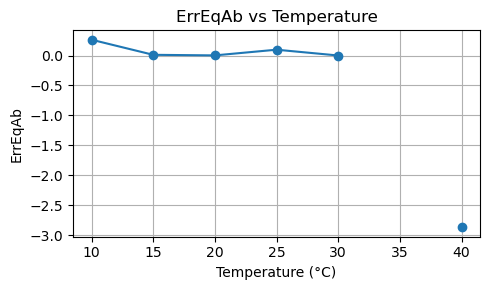

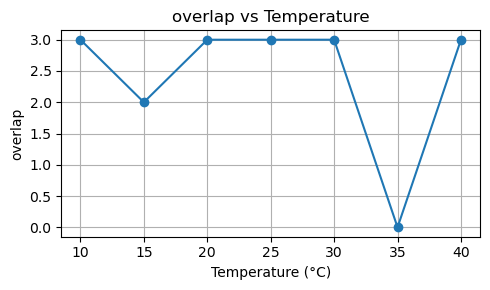

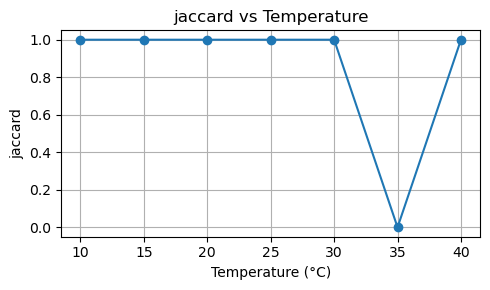

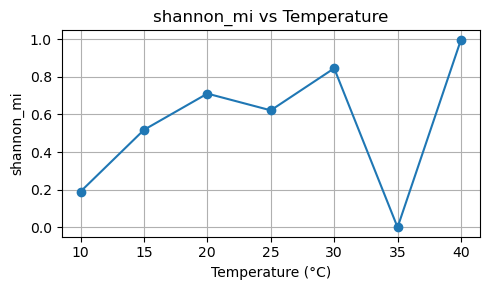

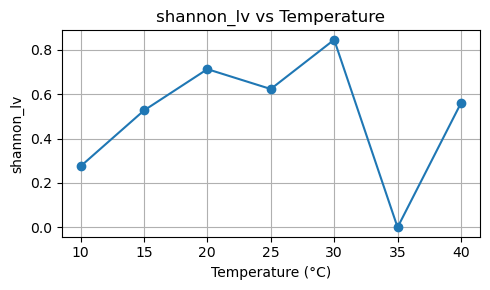

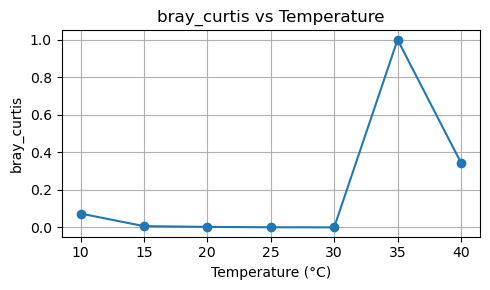

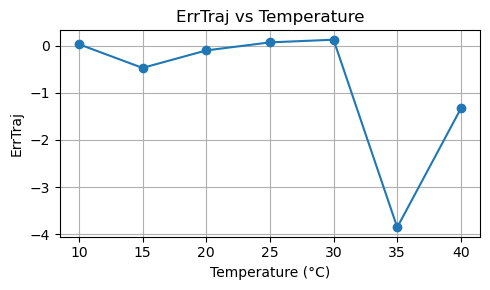

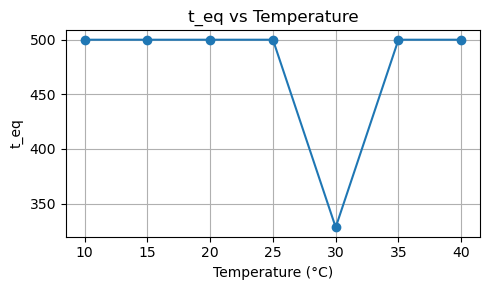

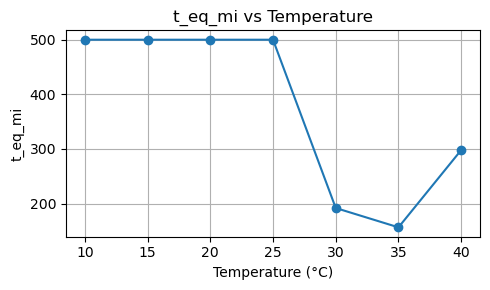

c:\Users\Chan Li\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


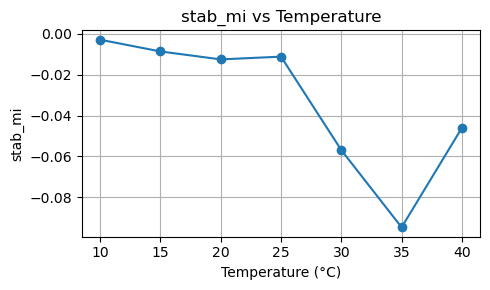

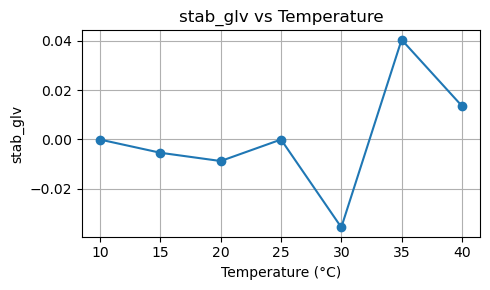

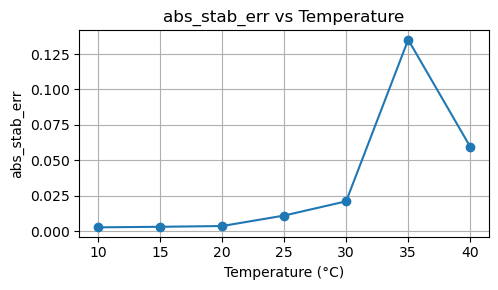

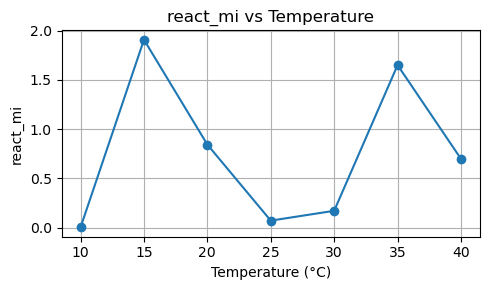

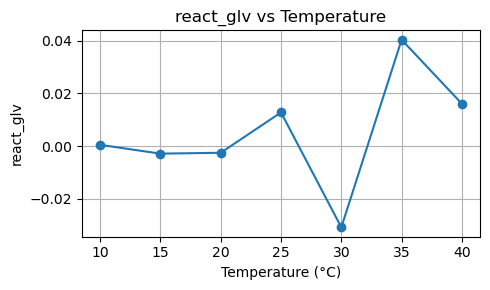

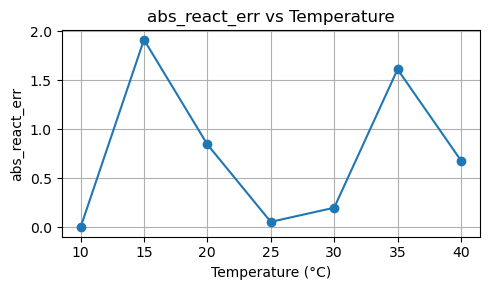

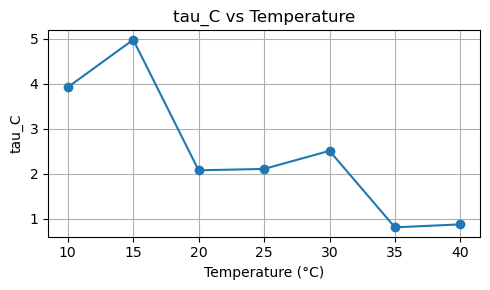

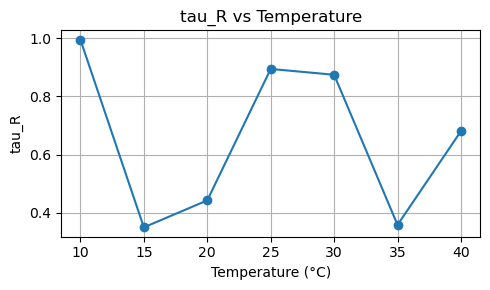

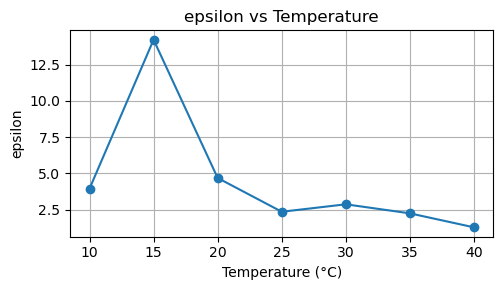

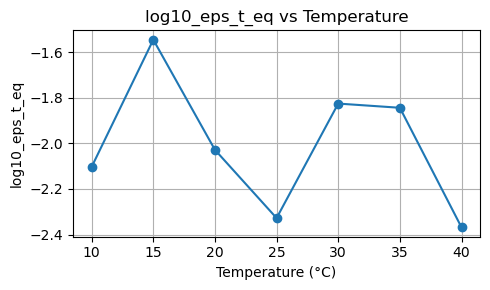

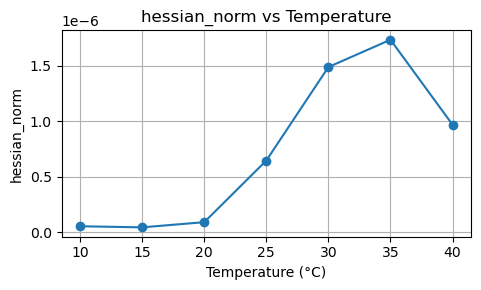

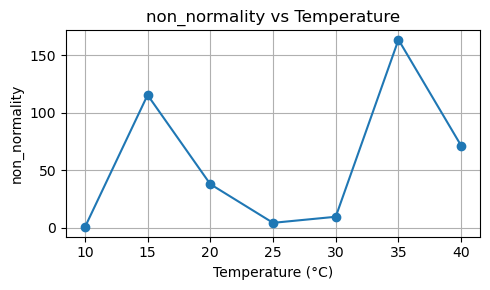

Test run complete: Plotted metrics for replicate 1


In [10]:
import os
import pickle
import numpy as np
import pandas as pd
from numpy.random import default_rng
from scipy.integrate import solve_ivp
import multiprocessing as mp


# ─── Output directories ───────────────────────────────
outdir = "output"
os.makedirs(outdir, exist_ok=True)
paramfile = os.path.join(outdir, "structural_params_all.pkl")

# ─── Simulation parameters ────────────────────────────
N         = 7
M         = 5
L         = np.full(N, 0.3)
x0        = np.concatenate([np.full(N, 0.1), np.full(M, 1)])
temp_vals = np.linspace(283.15, 313.15, 7)  # 10 °C to 40 °C
rho_t     = np.array([-0.5, -0.5])
Tr        = 283.15 + 10
Ed        = 3.5
rp        = 1
ttscle    = 100
tint      = 500
t_eval    = np.linspace(0, tint, ttscle)

# ─── Combined replicate function ────────────────────────────
def run_single_replicate(rep_id):
    structural = generate_params(
        N, M,
        f_u=def_u, f_m=def_m, f_rho=def_rho,
        f_omega=def_omega, f_l=def_l,
        L=L, T=Tr, rho_t=rho_t, Tr=Tr, Ed=Ed,
        rng=default_rng(111 + rep_id)
    )

    metrics = []

    for T in temp_vals:

        # Temperature-dependent params
        temp_p, _, _, _ = temp_trait(N, {'T':T,'Tr':Tr,'Ed':Ed,'rho_t':rho_t,'L':L})
        pT = {**structural,
             'u': structural['u']*temp_p[:,0][:,None],
             'm': temp_p[:,1],
             'lambda': structural['l'].sum(axis=2),
             'T': T}
        
        # MiCRM solve
        sol = solve_ivp(
            lambda t,y: MiCRM_dxx_numba_wrapper(t,y,pT),
            (0, tint), x0,
            method='LSODA', rtol=1e-4, atol=1e-7,
            t_eval=t_eval)
        
        # GLV fit and solve
        p_lv = eff_LV_params(pT, sol, verbose=False)
        sol_lv = solve_ivp(
            lambda t,y: LV_dx(y,t,p_lv),
            (0, tint), sol.y[:N,0],
            method='LSODA', rtol=1e-4, atol=1e-7,
            t_eval=t_eval)
        
        # Equilibria
        Cmi_eq = sol.y[:N,-1]
        Rmi_eq = sol.y[N:,-1]
        Clv_eq = sol_lv.y[:N,-1]

        # Deviations & diversity
        ErrEqAb, overlap = err_eq_and_overlap(Clv_eq, Cmi_eq)
        jaccard = jaccard_index(Clv_eq, Cmi_eq, thresh=1e-6)
        sh_mi = shannon(Cmi_eq)
        sh_lv = shannon(Clv_eq)
        bc = bray_curtis_dissimilarity(Clv_eq, Cmi_eq)

        # Trajectory error
        err_t,_ = err_time_series(sol.t, sol_lv.y[:N], sol.y[:N])
        j_eq = estimate_teq_traj(sol.t, sol, sol_lv, pT, p_lv, tol=1e-6, window=5)
        ErrTraj = integrate_err(sol.t[:j_eq+1], err_t[:j_eq+1])
        t_eq_index = estimate_teq_timescale(sol.t, sol, pT)
        t_eq_mi = sol.t[t_eq_index]

        # Stability & reactivity
        J_m = MiCRM_jac(pT, sol)
        stab_mi = leading_eigenvalue(J_m)
        react_mi = leading_hermitian_eigenvalue(J_m)

        J_lv_m = eff_LV_jac(p_lv, sol)
        stab_glv = leading_eigenvalue(J_lv_m)
        react_glv = leading_hermitian_eigenvalue(J_lv_m)

        # Timescale separation
        tau_C, tau_R, eps = timescale_separation_full(J_m, N)
        log10_eps_t_eq = np.log10(eps / t_eq_mi)

        # Hessian & non-normality
        hnorm = compute_hessian_norm_nb(
            Cmi_eq, N, M,
            pT['u'], pT['lambda'], pT['rho'],
            pT['omega'], pT['l'], pT['m'], eps=1e-6)
        
        comm = J_m @ J_m.T - J_m.T @ J_m
        nnorm = np.linalg.norm(comm, ord='fro')

        # Pack metrics with original column names
        metrics.append({
            'replicate': rep_id,
            'T_K': T,
            'T_C': T-273.15,
            'ErrEqAb': ErrEqAb,
            'overlap': overlap,
            'jaccard': jaccard,
            'shannon_mi': sh_mi,
            'shannon_lv': sh_lv,
            'bray_curtis': bc,
            'ErrTraj': ErrTraj,
            't_eq': sol.t[j_eq],
            't_eq_mi': t_eq_mi,
            'stab_mi': stab_mi,
            'stab_glv': stab_glv,
            'abs_stab_err': abs(stab_glv - stab_mi),
            'react_mi': react_mi,
            'react_glv': react_glv,
            'abs_react_err': abs(react_glv - react_mi),
            'tau_C': tau_C,
            'tau_R': tau_R,
            'epsilon': eps,
            'log10_eps_t_eq': log10_eps_t_eq,
            'hessian_norm': hnorm,
            'non_normality': nnorm
        })
    return {'rep_id': rep_id, 'struct': structural, 'record': metrics}


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import pandas as pd

    # Single replicate test run
    rep_id = 1
    result = run_single_replicate(rep_id)
    df = pd.DataFrame(result['record'])
    df['T_C'] = df['T_K'] - 273.15

    # Plot every metric vs temperature
    plot_cols = [col for col in df.columns if col not in ['replicate', 'T_K', 'T_C']]
    for col in plot_cols:
        plt.figure(figsize=(5,3))
        plt.plot(df['T_C'], df[col], marker='o', linestyle='-')
        plt.title(f'{col} vs Temperature')
        plt.xlabel('Temperature (°C)')
        plt.ylabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    print('Test run complete: Plotted metrics for replicate', rep_id)



below: test for stability graph 

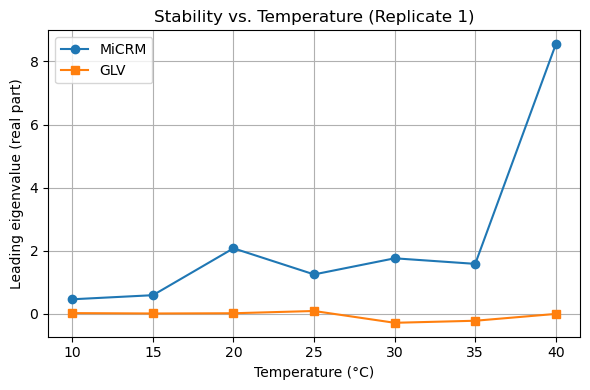

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.integrate import solve_ivp


# ─── Simulation parameters ────────────────────────────
N        = 7
M        = 5
L        = np.full(N, 0.3)
x0       = np.concatenate([np.full(N, 0.1), np.full(M, 1)])
temp_vals= np.linspace(283.15, 313.15, 7)  # 10 °C to 40 °C
rho_t    = np.array([-0.5, -0.5])
Tr       = 283.15
Ed       = 3.5
rep_id   = 1  # single replicate for testing
ttscle   = 100
tint     = 300
t_eval   = np.linspace(0, tint, ttscle)

# ─── Single replicate simulation + metrics ─────────────────────────
def run_single_replicate(replicate_id):
    # Generate structural parameters
    structural = generate_params(
        N, M,
        f_u=def_u, f_m=def_m, f_rho=def_rho,
        f_omega=def_omega, f_l=def_l,
        L=L,
        T=Tr, rho_t=rho_t, Tr=Tr, Ed=Ed,
        rng=default_rng(111 + replicate_id)
    )
    metrics = []

    for T in temp_vals:
        # Temperature-dependent parameters
        temp_p, _, _, _ = temp_trait(N, {'T': T, 'Tr': Tr, 'Ed': Ed, 'rho_t': rho_t, 'L': L})
        pT = {
            **structural,
            'u': structural['u'] * temp_p[:, 0][:, None],
            'm': temp_p[:, 1],
            'lambda': structural['l'].sum(axis=2),
            'T': T
        }

        # Solve MiCRM
        sol_m = solve_ivp(
            lambda t, y: MiCRM_dxx_numba_wrapper(t, y, pT),
            (0, tint), x0,
            method='BDF', rtol=1e-6, atol=1e-9,
            t_eval=t_eval
        )
    
        # Fit GLV parameters
        p_lv = eff_LV_params(pT, sol_m, verbose=False)

        # Solve GLV from MiCRM equilibrium
        sol_lv = solve_ivp(
            lambda t, y: LV_dx(y, t, p_lv),
            (0, tint), sol_m.y[:N, -1],
            method='BDF', rtol=1e-6, atol=1e-9,
            t_eval=t_eval
        )

        # Extract equilibria
        Cmi_eq = sol_m.y[:N, -1]
        Rmi_eq = sol_m.y[N:, -1]
        Clv_eq = sol_lv.y[:N, -1]

        # Deviations & diversity metrics
        ErrEq, overlap = err_eq_and_overlap(Clv_eq, Cmi_eq)
        jacc         = jaccard_index(Clv_eq, Cmi_eq, thresh=1e-6)
        sh_mi, sh_lv = shannon(Cmi_eq), shannon(Clv_eq)
        bc           = bray_curtis_dissimilarity(Clv_eq, Cmi_eq)

        # Trajectory error & timescales
        err_t, _     = err_time_series(sol_m.t, sol_lv.y[:N], sol_m.y[:N])
        j_eq         = estimate_teq_traj(sol_m.t, sol_m, sol_lv, pT, p_lv, tol=1e-6, window=5)
        ErrTraj      = integrate_err(sol_m.t[:j_eq+1], err_t[:j_eq+1])
        j_eq_mi      = estimate_teq_timescale(sol_m.t, sol_m, pT)
        t_eq_mi      = sol_m.t[j_eq_mi]

        # Stability & reactivity
        J_mic        = MiCRM_jac(pT, sol_m)
        stab_mic     = leading_eigenvalue(J_mic)
        react_mic    = leading_hermitian_eigenvalue(J_mic)

        J_lv_mat     = eff_LV_jac(p_lv, sol_m)
        stab_glv     = leading_eigenvalue(J_lv_mat)
        react_glv    = leading_hermitian_eigenvalue(J_lv_mat)

        # Timescale separation
        tau_C, tau_R, eps = timescale_separation_full(J_mic, N)
        log10_eps_teq    = np.log10(eps / t_eq_mi)

        # Hessian norm & non-normality
        hnorm = compute_hessian_norm_nb(
            Cmi_eq, N, M,
            pT['u'], pT['lambda'], pT['rho'],
            pT['omega'], pT['l'], pT['m'],
            eps=1e-6
        )
        comm  = J_mic @ J_mic.T - J_mic.T @ J_mic
        nnorm = np.linalg.norm(comm, ord='fro')

        # Collect metrics
        metrics.append({
            'replicate': replicate_id,
            'T_K': T,
            'T_C': T - 273.15,
            'ErrEqAb': ErrEq,
            'overlap': overlap,
            'jaccard': jacc,
            'shannon_mi': sh_mi,
            'shannon_lv': sh_lv,
            'bray_curtis': bc,
            'ErrTraj': ErrTraj,
            't_eq': sol_m.t[j_eq],
            't_eq_mi': t_eq_mi,
            'stab_mic': stab_mic,
            'stab_glv': stab_glv,
            'react_mic': react_mic,
            'react_glv': react_glv,
            'abs_stab_err': abs(stab_glv - stab_mic),
            'abs_react_err': abs(react_glv - react_mic),
            'tau_C': tau_C,
            'tau_R': tau_R,
            'epsilon': eps,
            'log10_eps_t_eq': log10_eps_teq,
            'hessian_norm': hnorm,
            'non_normality': nnorm
        })

    return metrics

# ─── Run single replicate and plot ─────────────────────
metrics = run_single_replicate(rep_id)

df = pd.DataFrame(metrics)
df['T_C'] = df['T_K'] - 273.15

plt.figure(figsize=(6,4))
plt.plot(df['T_C'], df['stab_mic'], marker='o', label='MiCRM')
plt.plot(df['T_C'], df['stab_glv'], marker='s', label='GLV')
plt.xlabel('Temperature (°C)')
plt.ylabel('Leading eigenvalue (real part)')
plt.title('Stability vs. Temperature (Replicate 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ignore below for now (two part verison, from newchan.py)

In [ ]:
"""
this calculates equilibrium values (C*, R*) + trajectory errors 
计算平衡值 (C*, R*) + 轨迹误差
"""


# ─── Output directories ───────────────────────────────
outdir = "output"  # 定义输出目录路径字符串
os.makedirs(outdir, exist_ok=True)  # 创建输出目录（如果不存在）

paramfile = os.path.join(outdir, "structural_params_all.pkl")  # 拼接参数文件路径字符串

# ─── Simulation parameters ────────────────────────────
N = 15  # 消费者数量（整数）
M = 8   # 资源数量（整数）
L = np.full(N, 0.3)  # 创建长度为N的全0.3向量（泄漏率参数）
intem = 6  # 温度分组（整数）
x0 = np.concatenate([np.full(N, 0.1), np.full(M, 1)])  # 初始状态向量（前N个0.1是消费者，后M个1是资源）
temp_vals = np.linspace(273.15+10, 273.15 + 40, intem+1)  # 温度梯度数组（31个点，从273.15K到303.15K）
rho_t = np.array([-0.5, -0.5])  # 温度相关系数向量（长度2）
Tr = 273.15 + 10  # 参考温度（283.15K）
Ed = 3.5  # 去活化能（浮点数）
rp = 100  # 重复次数（整数）
ttscle = 100  # 时间点（整数）
tint = 500   # 时间尺度（整数）

# ─── Per‐replicate function ───────────────────────────
def run_single_full_raw(replicate_id):
    # 生成MiCRM结构参数（调用generate_params函数）
    structural = generate_params(
        N, M,  # 消费者和资源数量
        f_u=def_u, f_m=def_m, f_rho=def_rho,  # 使用默认参数生成函数
        f_omega=def_omega, f_l=def_l,
        L=L,  # 泄漏率向量
        T=283.15, rho_t=rho_t, Tr=Tr, Ed=Ed,  # 温度参数
        rng=default_rng(111+replicate_id)  # 固定随机种子
    )
    raw_rows = []  # 存储原始数据的列表
    traj_rows = []  # 存储轨迹指标的列表

    for T in temp_vals:  # 遍历所有温度点

                # 计算温度依赖性状（调用temp_trait函数）
        temp_p, _, _, _ = temp_trait(N, {
            'T': T, 'Tr': Tr, 'Ed': Ed, 'rho_t': rho_t, 'L': L
        })

        # 构建温度修正后的参数字典
        pT = {
            **structural,  # 解包原始参数
            'u': structural['u'] * temp_p[:, 0][:, None],  # 温度修正的摄取矩阵
            'm': temp_p[:, 1],  # 温度修正的死亡率
            'lambda': np.sum(structural['l'], axis=2),  # 总泄漏率
            'T': T  # 当前温度
        }

        # ─── 数值求解MiCRM模型 ────────────────────────
        t_eval = np.linspace(0, tint, ttscle)  # 时间评价点（500个点）
        sol = solve_ivp(
            lambda t, y: MiCRM_dxx_numba_wrapper(t, y, pT),  # ODE右端函数
            (0, tint), x0, method='LSODA',  # 时间范围和初值
            rtol=1e-4, atol=1e-7, t_eval=t_eval  # 容差设置
        )

        # 计算有效LV参数（调用eff_LV_params函数）
        p_lv = eff_LV_params(pT, sol, verbose=False)

        # 数值求解GLV模型
        sol_lv = solve_ivp(
            lambda t, y: LV_dx(y, t, p_lv),
            (0, tint), sol.y[:N, 0], method='LSODA',
            rtol=1e-4, atol=1e-7, t_eval=t_eval
        )

        # ─── 记录平衡态结果 ──────────────────────────
        C_eq_mi = sol.y[:N, -1]  # MiCRM消费者平衡态（长度N向量）
        R_eq_mi = sol.y[N:, -1]  # MiCRM资源平衡态（长度M向量）
        C_eq_lv = sol_lv.y[:N, -1]  # GLV消费者平衡态


        # 构建原始数据记录字典
        raw_data = {
            'replicate': replicate_id,
            'T_K':       T,
            'T_C':       T - 273.15
        }

        # 添加每个消费者和资源的平衡值
        for i in range(N):
            raw_data[f'Cmi_{i}'] = C_eq_mi[i]  # MiCRM消费者i的平衡值
            raw_data[f'Clv_{i}'] = C_eq_lv[i]  # GLV消费者i的平衡值
        for j in range(M):
            raw_data[f'Rmi_{j}'] = R_eq_mi[j]  # MiCRM资源j的平衡值

        raw_rows.append(raw_data)
        
        # ─── 计算轨迹指标 ───────────────────────────
        times = sol.t  # 获取时间点
        err_t, _ = err_time_series(times, sol_lv.y[:N], sol.y[:N])  # 计算误差时间序列



        # 估计平衡时间（调用estimate_teq_traj函数）
        j_eq = estimate_teq_traj(times, sol, sol_lv, pT, p_lv, tol=1e-6, window=5)
        times_crop = times[: j_eq + 1]  # 截取达到平衡前的时间段
        err_crop = err_t[: j_eq + 1]    # 对应误差

        # 计算平均轨迹误差（调用integrate_err函数）
        ErrTraj = integrate_err(times_crop, err_crop)

        # 计算MiCRM系统平衡时间
        j_eq_mi = estimate_teq_timescale(sol.t, sol, pT)
        t_eq_mi = sol.t[j_eq_mi]

        # 存储轨迹指标
        traj_metrics = {
            'replicate': replicate_id,
            'T_K':       T,
            'T_C':       T - 273.15,
            't_eq':      times[j_eq],   # 两模型共同平衡时间
            'ErrTraj':   ErrTraj,       # 平均轨迹误差
            't_eq_mi':   t_eq_mi        # MiCRM单独平衡时间
        }
        
        traj_rows.append(traj_metrics)

    return replicate_id, structural, raw_rows, traj_rows


In [ ]:
def run_analyze_save(rep_id):
    rep_id, struct, raw_rows, traj_rows = run_single_full_raw(rep_id)
    
    # 构造DataFrame便于操作
    df_eq   = pd.DataFrame(raw_rows)
    df_traj = pd.DataFrame(traj_rows)

    df_eq_rep   = df_eq.set_index('T_K')
    df_traj_rep = df_traj.set_index('T_K')
    temps = sorted(df_eq['T_K'].unique())

    # 预计算温度缩放因子
    temp_scalars = {
        T_K: temp_trait(N, {'T':T_K, 'Tr':273.15+10, 'Ed':3.5, 'rho_t':np.array([0.0,0.0]), 'L':np.full(N,0.3)})[0]
        for T_K in temps
    }

    class SolDummy: pass
    records = []

    for T_K in temps:
        row_eq = df_eq_rep.loc[T_K]
        Cmi = row_eq.filter(like='Cmi_').values
        Clv = row_eq.filter(like='Clv_').values
        Rmi = row_eq.filter(like='Rmi_').values
        T_C = T_K - 273.15
        t_eq_mi = df_traj_rep.loc[T_K, 't_eq_mi']

        ErrEqAb, overlap = err_eq_and_overlap(Clv, Cmi)
        jacc = jaccard_index(Clv, Cmi, thresh=1e-6)
        sh_mi, sh_lv = shannon(Cmi), shannon(Clv)
        bc = bray_curtis_dissimilarity(Clv, Cmi)

        temp_p = temp_scalars[T_K]
        pT = {
            **struct,
            'u': struct['u'] * temp_p[:, 0][:, None],
            'm': temp_p[:, 1],
            'lambda': struct['l'].sum(axis=2),
            'T': T_K
        }

        sol_eq = SolDummy()
        sol_eq.y = np.concatenate([Cmi, Rmi])[:, None]
        sol_eq.t = np.array([t_eq_mi])

        p_lv = eff_LV_params(pT, sol_eq, verbose=False)
        J_glv = eff_LV_jac(p_lv, sol_eq)
        stab_glv = leading_eigenvalue(J_glv)
        react_glv = leading_hermitian_eigenvalue(J_glv)

        J_mic = MiCRM_jac(pT, sol_eq)
        stab_mic = leading_eigenvalue(J_mic)
        react_mic = leading_hermitian_eigenvalue(J_mic)

        tau_C, tau_R, eps = timescale_separation_full(J_mic, N)
        log10_eps_teq = np.log10(eps / t_eq_mi)

        hnorm = compute_hessian_norm_nb(
            Cmi, N, M,
            pT['u'], pT['lambda'], pT['rho'],
            pT['omega'], pT['l'], pT['m'],
            eps=1e-6
        )

        comm = J_mic @ J_mic.T - J_mic.T @ J_mic
        nnorm = np.linalg.norm(comm, ord='fro')

        records.append({
            'replicate': rep_id,
            'T_K': T_K,
            'T_C': T_C,
            'ErrEqAb': ErrEqAb,
            'overlap': overlap,
            'jaccard': jacc,
            'shannon_mi': sh_mi,
            'shannon_lv': sh_lv,
            'bray_curtis': bc,
            'stab_glv': stab_glv,
            'stab_mi': stab_mic,
            'abs_stab_err': abs(stab_glv - stab_mic),
            'react_glv': react_glv,
            'react_mi': react_mic,
            'abs_react_err': abs(react_glv - react_mic),
            'tau_C': tau_C,
            'tau_R': tau_R,
            'epsilon': eps,
            't_eq_mi': t_eq_mi,
            'log10_eps_t_eq': log10_eps_teq,
            'hessian_norm': hnorm,
            'non_normality': nnorm
        })

    return {
        'rep_id': rep_id,
        'record': records,
        'struct': struct,
        'raw': raw_rows,
        'traj': traj_rows
    }

if __name__ == '__main__':
    num_processes = int(os.environ.get('NUM_PROCESSES', mp.cpu_count()))
    full_ids = list(range(1, rp + 1))

    with mp.Pool(num_processes) as pool:
        results = pool.map(run_analyze_save, full_ids)

    # 聚合所有结果
    metrics = [r for result in results for r in result['record']]
    struct_all = {result['rep_id']: result['struct'] for result in results}
    raw_all = [row for result in results for row in result['raw']]
    traj_all = [row for result in results for row in result['traj']]

    # 写入输出文件
    pd.DataFrame(metrics).to_csv(os.path.join(outdir, 'metrics_100.csv'), index=False)
    pd.DataFrame(raw_all).to_csv(os.path.join(outdir, 'raw_eq_100.csv'), index=False)
    pd.DataFrame(traj_all).to_csv(os.path.join(outdir, 'traj_100.csv'), index=False)

    with open(paramfile, 'wb') as f:
        pickle.dump(struct_all, f)

    print("Done:\n • raw_eq_100.csv\n • traj_100.csv\n • metrics_100.csv\n • structural_params_all.pkl")


